1. train/test - 0.7/0.3
1. padding 1
1. confustion matrix \
    - 무엇을 못 맞추는가. (실제 control - 예측 pd인게 얼마나 많은가) --> stratified --> conv 모델 구축 --> 데이터 증강 효과 확인 --> 
    - 만약, pd-control and control-pd가 많으면 정말...... 놉 --> conv 모델? fw/bw 분리? 확인 필요 

In [1]:
# 39개 마커
MARKERS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'LSHO', 'RSHO', 'CLAV', 'RBAK',
           'LUPA', 'RUPA', 'STRN', 'T10', 'LELB', 'RELB', 'LFRM', 'RFRM',
           'LWRA', 'RWRA', 'LWRB', 'RWRB', 'LFIN', 'RFIN', 'LASI', 'RASI',
           'LPSI', 'RPSI', 'LTHI', 'RTHI', 'LKNE', 'RKNE', 'LTIB', 'RTIB',
           'LANK', 'RANK', 'LTOE', 'RTOE', 'LHEE', 'RHEE']
len(MARKERS)

39

In [2]:
import os
import glob

import pandas as pd
import numpy as np
from PIL import Image 
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
DATAPATH = "/Users/sujinlee/Desktop/nims/pd/dataset"
CONTROL = os.path.join(DATAPATH, "Controls")
PD = os.path.join(DATAPATH, "PD")

df_patients = pd.read_csv(os.path.join(DATAPATH, "patients.csv"))
df_null_info = pd.read_csv(os.path.join(DATAPATH, "NULL_info.csv"))

In [4]:
df_patients.head()

,Patient,Category,cntFW,cntBW,pathFW,pathBW
0,AMJ,PD,3,3,"['./dataset/PD/PREP_AMJ_FW1.csv', './dataset/P...","['./dataset/PD/PREP_AMJ_BW1.csv', './dataset/P..."
1,BDY,PD,3,3,"['./dataset/PD/PREP_BDY_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BDY_BW1.csv', './dataset/P..."
2,BGH,PD,3,3,"['./dataset/PD/PREP_BGH_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BGH_BW1.csv', './dataset/P..."
3,BHJ,PD,3,3,"['./dataset/PD/PREP_BHJ_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BHJ_BW1.csv', './dataset/P..."
4,BSB,PD,3,2,"['./dataset/PD/PREP_BSB_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BSB_BW1.csv', './dataset/P..."


In [5]:
len(df_patients)*3

315

In [6]:
df_patients[df_patients["cntFW"] != 3]

,Patient,Category,cntFW,cntBW,pathFW,pathBW
47,KMS,PD,2,3,"['./dataset/PD/PREP_KMS_FW1.csv', './dataset/P...","['./dataset/PD/PREP_KMS_BW1.csv', './dataset/P..."


#### 데이터 개수 확인

In [7]:
np.sum(df_patients[df_patients["Category"] == "PD"]["cntFW"].values)

248

In [8]:
np.sum(df_patients[df_patients["Category"] == "Controls"]["cntFW"].values)

66

In [9]:
248+66 - 1

313

In [10]:
248+227

475

In [11]:
66+66

132

In [12]:
132/(475+132)

0.21746293245469522

In [13]:
np.sum(df_patients[df_patients["Category"] == "PD"]["cntBW"].values)

227

In [14]:
np.sum(df_patients[df_patients["Category"] == "Controls"]["cntBW"].values)

66

In [15]:
227+66 - 1

292

In [16]:
605*0.8

484.0

In [17]:
df_null_info.head()

,Unnamed: 0,path,category,name,trial,marker,NULL frames,frame length,ratio,remove
0,0,./dataset/PD/PREP_AMJ_BW1.csv,PD,AMJ,BW1,LTIB,"[[0.9988, 1.0]]",847,0.0024,False
1,1,./dataset/PD/PREP_AMJ_BW3.csv,PD,AMJ,BW3,LWRB,"[[0.0, 0.0219]]",867,0.0231,False
2,2,./dataset/PD/PREP_AMJ_FW1.csv,PD,AMJ,FW1,LUPA,"[[0.0, 0.0045]]",441,0.0068,False
3,3,./dataset/PD/PREP_AMJ_FW2.csv,PD,AMJ,FW2,LTHI,"[[0.0, 0.0266]]",339,0.0295,False
4,4,./dataset/PD/PREP_AMJ_FW3.csv,PD,AMJ,FW3,LWRA,"[[0.9944, 1.0]]",355,0.0085,False


In [18]:
# 사용하지 않을 데이터 \
# PD/KMS_FW3.csv : 원본 데이터에 ‘RFHD’ 마커가 없음. \
# PD/BGH_FW1.csv : NULL인 컬럼이 너무 많음.

EXCLUDE = [["KMS", "FW3"], ["BGH", "FW1"]]

### 1. frame 수 결정

In [19]:
# null 있는 사람의 trial 별 frame 길이 비교
FRAME = np.max(df_null_info["frame length"])

target = set([ name + "_" + trial for name, trial in zip(df_null_info["name"].values, df_null_info["trial"].values) ])
print("LEN:", len(target))

for t in target:
    name = t.split('_')[0]
    trial = t.split('_')[1]
    print(name, trial)
    
    if not (name == "KMS" and trial == "FW3") and not (name == "BGH" and (trial == "FW1" or trial == "BW1")):
    
        df_t = df_null_info[(df_null_info["name"] == name) & (df_null_info["trial"] == trial)]
        len_t = np.round(df_t["frame length"].values * (1 - df_t["ratio"].values))[0].astype("int64")

        FRAME = min(FRAME, len_t)
        print(FRAME)

LEN: 28
AMJ FW3
352
AMJ BW1
352
NTH BW2
352
SHI BW1
352
ParkSD BW2
352
CHH BW3
352
KES BW2
352
JHY FW1
268
BHY FW1
266
KimYC BW3
266
BGH FW1
BHY FW2
266
HSH FW2
266
ODS FW2
266
ODS FW1
266
AMJ FW1
266
JJG FW1
266
BDY FW3
266
BGH BW1
AMJ FW2
266
AMJ BW3
266
ParkSD FW2
266
NTH BW1
266
NTH FW1
266
JHY BW1
266
ODS BW2
266
BHY BW3
266
KES FW2
266


In [20]:
print("min frame:", FRAME)

min frame: 266


In [21]:
# 전체 데이터 frame 길이 비교
for cate, name, nFW, nBW in zip(df_patients["Category"].values, df_patients["Patient"].values, df_patients["cntFW"].values, df_patients["cntBW"].values):    
    for idx in range(1, nFW+1):
        df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_FW{idx}.csv"))
        print(name, f"FW{idx}")
        print(len(df))
        FRAME = min(FRAME, len(df))
        
    for idx in range(1, nBW+1):
        df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_BW{idx}.csv"))
        print(name, f"BW{idx}")
        print(len(df))
        FRAME = min(FRAME, len(df))

AMJ FW1
441
AMJ FW2
339
AMJ FW3
355
AMJ BW1
847
AMJ BW2
674
AMJ BW3
867
BDY FW1
312
BDY FW2
284
BDY FW3
300
BDY BW1
449
BDY BW2
417
BDY BW3
376
BGH FW1
523
BGH FW2
219
BGH FW3
237
BGH BW1
563
BGH BW2
368
BGH BW3
422
BHJ FW1
674
BHJ FW2
597
BHJ FW3
653
BHJ BW1
1095
BHJ BW2
879
BHJ BW3
1048
BSB FW1
711
BSB FW2
812
BSB FW3
776
BSB BW1
1688
BSB BW2
1957
BSR FW1
235
BSR FW2
216
BSR FW3
226
BSR BW1
345
BSR BW2
321
BSR BW3
278
BTC FW1
379
BTC FW2
400
BTC FW3
366
BTC BW1
470
BTC BW2
1171
BTC BW3
1297
BYH FW1
301
BYH FW2
275
BYH FW3
259
BYH BW1
453
BYH BW2
548
BYH BW3
569
CCC FW1
207
CCC FW2
243
CCC FW3
227
CCC BW1
453
CCC BW2
334
CCC BW3
350
CCD FW1
284
CCD FW2
259
CCD FW3
252
CHK FW1
335
CHK FW2
277
CHK FW3
228
CIB FW1
288
CIB FW2
289
CIB FW3
290
CIB BW1
439
CIB BW2
449
CIB BW3
375
CJH FW1
232
CJH FW2
269
CJH FW3
238
CJH BW1
353
CJH BW2
292
CJH BW3
319
CKC FW1
234
CKC FW2
324
CKC FW3
303
CKC BW1
288
CKC BW2
419
CKC BW3
476
CMJ FW1
286
CMJ FW2
263
CMJ FW3
246
CMJ BW1
633
CMJ BW2
576
CMJ BW3
37

In [27]:
print("min frame:", FRAME)

min frame: 192


### 2. x,y,z 3-channel

In [22]:
DATAPATH

'/Users/sujinlee/Desktop/nims/pd/dataset'

In [23]:
print("PD count:", np.sum(df_patients[df_patients["Category"] == "PD"]["cntFW"].values) + np.sum(df_patients[df_patients["Category"] == "PD"]["cntBW"].values))
print("Controls count:", np.sum(df_patients[df_patients["Category"] == "Controls"]["cntFW"].values) + np.sum(df_patients[df_patients["Category"] == "Controls"]["cntBW"].values))

PD count: 475
Controls count: 132


In [24]:
DATAPATH_IMG = DATAPATH + "_img"
DATAPATH_NP = DATAPATH + "_np"

In [25]:
os.path.exists(DATAPATH_IMG)

True

In [26]:
os.mkdir(DATAPATH_IMG)
os.mkdir(os.path.join(DATAPATH_IMG, "Controls"))
os.mkdir(os.path.join(DATAPATH_IMG, "PD"))

os.mkdir(DATAPATH_NP)
os.mkdir(os.path.join(DATAPATH_NP, "Controls"))
os.mkdir(os.path.join(DATAPATH_NP, "PD"))

FileExistsError: [Errno 17] File exists: '/Users/sujinlee/Desktop/nims/pd/dataset_img'

In [ ]:
print(len(os.listdir(os.path.join(DATAPATH_IMG, "Controls"))))
print(len(os.listdir(os.path.join(DATAPATH_IMG, "PD"))))

In [ ]:
print(len(os.listdir(os.path.join(DATAPATH_NP, "Controls"))))
print(len(os.listdir(os.path.join(DATAPATH_NP, "PD"))))

In [32]:
# 전체 데이터 x,y,z
for cate, name, nFW, nBW in zip(df_patients["Category"].values, df_patients["Patient"].values, df_patients["cntFW"].values, df_patients["cntBW"].values):    
    for idx in range(1, nFW+1):
        
        if not (name == "KMS" and idx == 3) and not (name == "BGH" and idx == 1):
            
            df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_FW{idx}.csv"))
            df_sample = df.copy()

            # x, y, z 추출
            df_x = df_sample.filter(regex='X')
            df_y = df_sample.filter(regex='Y')
            df_z = df_sample.filter(regex='Z')

            # MARKERS 컬럼들인지 확인 
            print("LEN X:", len(df_x.columns))
            print("LEN Y:", len(df_y.columns))
            print("LEN Z:", len(df_z.columns))

            assert len(df_x.columns) == 39 and len(set([x.split('_')[0] for x in df_x]) - set(MARKERS)) == 0
            assert len(df_y.columns) == 39 and len(set([x.split('_')[0] for x in df_y]) - set(MARKERS)) == 0
            assert len(df_z.columns) == 39 and len(set([x.split('_')[0] for x in df_z]) - set(MARKERS)) == 0

            # 컬럼 순서 재 확인
            df_x = df_x[[m + "_X" for m in MARKERS]]
            df_y = df_y[[m + "_Y" for m in MARKERS]]
            df_z = df_z[[m + "_Z" for m in MARKERS]]

            # 3차원 벡터 생성
            df_img = np.stack([df_x, df_y, df_z], -1)
            
            # save numpy 
            np.save(os.path.join(os.path.join(DATAPATH_NP, cate), f"NP_{name}_FW{idx}.npy"), df_img)

            # save img
            from PIL import Image
            df_img_jpg = Image.fromarray(df_img.astype(np.uint8))
            df_img_jpg.save(os.path.join(os.path.join(DATAPATH_IMG, cate), f"IMG_{name}_FW{idx}.jpg"))

            print(name, f"FW{idx}")
            print(len(df))

    for idx in range(1, nBW+1):
        
        if not (name == "BGH" and idx == 1):
        
            df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_BW{idx}.csv"))
            df_sample = df.copy()

            # x, y, z 추출
            df_x = df_sample.filter(regex='X')
            df_y = df_sample.filter(regex='Y')
            df_z = df_sample.filter(regex='Z')

            # MARKERS 컬럼들인지 확인 
            print("LEN X:", len(df_x.columns))
            print("LEN Y:", len(df_y.columns))
            print("LEN Z:", len(df_z.columns))

            assert len(df_x.columns) == 39 and len(set([x.split('_')[0] for x in df_x]) - set(MARKERS)) == 0
            assert len(df_y.columns) == 39 and len(set([x.split('_')[0] for x in df_y]) - set(MARKERS)) == 0
            assert len(df_z.columns) == 39 and len(set([x.split('_')[0] for x in df_z]) - set(MARKERS)) == 0

            # 컬럼 순서 재 확인
            df_x = df_x[[m + "_X" for m in MARKERS]]
            df_y = df_y[[m + "_Y" for m in MARKERS]]
            df_z = df_z[[m + "_Z" for m in MARKERS]]

            # 3차원 벡터 생성
            df_img = np.stack([df_x, df_y, df_z], -1)
            
            # save numpy 
            np.save(os.path.join(os.path.join(DATAPATH_NP, cate), f"NP_{name}_BW{idx}.npy"), df_img)

            # save img
            from PIL import Image
            df_img_jpg = Image.fromarray(df_img.astype(np.uint8))
            df_img_jpg.save(os.path.join(os.path.join(DATAPATH_IMG, cate), f"IMG_{name}_BW{idx}.jpg"))

            print(name, f"BW{idx}")

LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ FW1
441
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ FW2
339
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ FW3
355
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ BW1
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY FW1
312
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY FW2
284
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY FW3
300
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY BW1
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH FW2
219
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH FW3
237
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ FW1
674
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ FW2
597
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ FW3
653
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ BW1
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BSB FW1
711
LEN X: 39
LEN Y: 39
LEN Z: 39
BSB FW2
812
LEN X: 39
LEN Y: 39
LEN Z: 39
BSB FW

In [27]:
name_sample = df_patients["Patient"].values[1]
df_sample = pd.read_csv(os.path.join(PD, f"PREP_{name_sample}_BW1.csv"))

In [28]:
df_sample.head()

,Frame,LFHD_X,LFHD_Y,LFHD_Z,RFHD_X,RFHD_Y,RFHD_Z,LBHD_X,LBHD_Y,LBHD_Z,...,LTOE_Z,RTOE_X,RTOE_Y,RTOE_Z,LHEE_X,LHEE_Y,LHEE_Z,RHEE_X,RHEE_Y,RHEE_Z
0,469,-94.588425,1265.890381,1472.445679,24.794617,1245.785645,1476.407349,-119.151863,1096.367920,1460.398804,...,31.684938,93.713570,1241.651001,60.347408,-57.385754,935.999695,35.451641,24.084532,1064.466675,89.558754
1,470,-94.585846,1265.635864,1472.480713,24.823648,1245.557129,1476.452515,-119.132408,1096.109741,1460.427734,...,31.687412,93.654007,1240.828979,60.382042,-57.386410,936.001892,35.445808,24.096382,1063.663208,89.839653
2,471,-94.576195,1264.502441,1472.637573,24.949701,1244.524414,1476.653442,-119.067604,1094.957886,1460.567627,...,31.700693,93.388199,1237.134033,60.548206,-57.430729,935.979858,35.428200,24.168474,1060.049683,91.078918
3,472,-94.560875,1261.966675,1472.995483,25.219524,1242.183716,1477.091309,-118.955185,1092.391602,1460.900024,...,31.734743,92.811363,1228.829590,60.953049,-57.592819,935.878967,35.387516,24.356722,1051.982178,93.854851
4,473,-94.543846,1257.867920,1473.583130,25.615763,1238.348267,1477.763916,-118.794563,1088.266724,1461.454102,...,31.805477,91.924492,1215.397583,61.669880,-57.883057,935.683716,35.290768,24.719568,1039.079834,98.360619


In [29]:
# x, y, z 추출
df_x = df.filter(regex='X')
df_y = df.filter(regex='Y')
df_z = df.filter(regex='Z')

In [30]:
# MARKERS 컬럼들인지 확인 
print("LEN X:", len(df_x.columns))
print("LEN Y:", len(df_y.columns))
print("LEN Z:", len(df_z.columns))

assert len(df_x.columns) == 39 and len(set([x.split('_')[0] for x in df_x]) - set(MARKERS)) == 0
assert len(df_y.columns) == 39 and len(set([x.split('_')[0] for x in df_y]) - set(MARKERS)) == 0
assert len(df_z.columns) == 39 and len(set([x.split('_')[0] for x in df_z]) - set(MARKERS)) == 0

LEN X: 39
LEN Y: 39
LEN Z: 39


In [31]:
# 컬럼 순서 재 확인
df_x = df_x[[m + "_X" for m in MARKERS]]
df_y = df_y[[m + "_Y" for m in MARKERS]]
df_z = df_z[[m + "_Z" for m in MARKERS]]

In [32]:
# 3차원 벡터 생성
df_img = np.stack([df_x, df_y, df_z], -1)

In [33]:
df_img.shape

(350, 39, 3)

In [34]:
# save img
from PIL import Image
df_img_jpg = Image.fromarray(df_img.astype(np.uint8))
df_img_jpg.save(os.path.join(DATAPATH, "your_file.jpg"))

In [35]:
# save numpy
np.save(os.path.join(DATAPATH, "sample.npy"), df_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


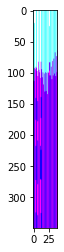

In [36]:
import matplotlib.pyplot as plt

plt.imshow(df_img)

### 3. resize 비교

#### 1) numpy.resize

In [37]:
img_np = df_x.values.copy()
print("Initial Size:", img_np.shape)
img_np.resize(200, 39)
print("After Resize:", img_np.shape)

Initial Size: (350, 39)
After Resize: (200, 39)


In [38]:
# 확인용

# 시작값
print("Idx   0 :", (img_np[0] == df_x.values[0]).all())

# 중간값
idx = int(len(img_np)/2)
print("Idx", idx, ": ", end='')
print((img_np[idx] == df_x.values[idx]).all())

# 끝값
print("Idx  -1 :", (img_np[-1] == df_x.values[len(img_np)-1]).all())

# 길이를 자른 것인지 확인
print("Is Crop ?", (img_np == df_x.values[:len(img_np)]).all())

Idx   0 : True
Idx 100 : True
Idx  -1 : True
Is Crop ? True


#### 2) tf.image.resize

<mark>bilinear</mark>: Bilinear interpolation. If antialias is true, becomes a hat/tent filter function with radius 1 when downsampling.\
<mark>lanczos3</mark>: Lanczos kernel with radius 3. High-quality practical filter but may have some ringing, especially on synthetic images.\
<mark>lanczos5</mark>: Lanczos kernel with radius 5. Very-high-quality filter but may have stronger ringing.\
<mark>bicubic</mark>: Cubic interpolant of Keys. Equivalent to Catmull-Rom kernel. Reasonably good quality and faster than Lanczos3Kernel, particularly when upsampling.\
<mark>gaussian</mark>: Gaussian kernel with radius 3, sigma = 1.5 / 3.0.\
<mark>nearest</mark>: Nearest neighbor interpolation. antialias has no effect when used with nearest neighbor interpolation.\
<mark>area</mark>: Anti-aliased resampling with area interpolation. antialias has no effect when used with area interpolation; it always anti-aliases.\
<mark>mitchellcubic</mark>: Mitchell-Netravali Cubic non-interpolating filter. For synthetic images (especially those lacking proper prefiltering), less ringing than Keys cubic kernel but less sharp.

##### - No option

In [188]:
img_tf = tf.constant(df_img)
img_tf = img_tf[tf.newaxis, ...]

In [189]:
print("Initial Size:", img_tf.shape.as_list())

img_tf_0_resized = tf.image.resize(img_tf[0], [200,39])
print("After Resize:", img_tf_0_resized.shape.as_list())

Initial Size: [1, 350, 39, 3]
After Resize: [200, 39, 3]


In [190]:
# 채널 분리
img_tf_0_x = img_tf_0_resized[:,:,0]
img_tf_0_y = img_tf_0_resized[:,:,1]
img_tf_0_z = img_tf_0_resized[:,:,2]

In [191]:
# 확인용

# 시작값
print("Idx   0 :", (img_tf_0_x[0].numpy() == df_x.values[0]).all())

# 중간값
idx = int(len(img_np)/2)
print("Idx", idx, ": ", end='')
print((img_tf_0_x[idx].numpy() == df_x.values[idx]).all())

# 끝값
print("Idx  -1 :", (img_tf_0_x[-1].numpy() == df_x.values[len(img_np)-1]).all())

# 길이를 자른 것인지 확인
print("Is Crop ?", (img_tf_0_x.numpy() == df_x.values[:len(img_np)]).all())

Idx   0 : False
Idx 100 : False
Idx  -1 : False
Is Crop ? False


##### - method: bilinear


In [192]:
print("Initial Size:", img_tf.shape.as_list())

img_tf_0_resized_bilinear = tf.image.resize(img_tf[0], [200,39], method="bilinear")
print("After Resize:", img_tf_0_resized_bilinear.shape.as_list())

Initial Size: [1, 350, 39, 3]
After Resize: [200, 39, 3]


In [193]:
# 채널 분리
img_tf_0_x_bilinear = img_tf_0_resized_bilinear[:,:,0]
img_tf_0_y_bilinear = img_tf_0_resized_bilinear[:,:,1]
img_tf_0_z_bilinear = img_tf_0_resized_bilinear[:,:,2]

In [194]:
# 확인용

# 시작값
print("Idx   0 :", (img_tf_0_x_bilinear[0].numpy() == df_x.values[0]).all())

# 중간값
idx = int(len(img_np)/2)
print("Idx", idx, ": ", end='')
print((img_tf_0_x_bilinear[idx].numpy() == df_x.values[idx]).all())

# 끝값
print("Idx  -1 :", (img_tf_0_x_bilinear[-1].numpy() == df_x.values[len(img_np)-1]).all())

# 길이를 자른 것인지 확인
print("Is Crop ?", (img_tf_0_x_bilinear.numpy() == df_x.values[:len(img_np)]).all())

Idx   0 : False
Idx 100 : False
Idx  -1 : False
Is Crop ? False


#### 3) tf.ImageDataGenerator(~, resize=)

#### 4) tf.keras.preprocessing.image.smart_resize
- interpolation\
String, interpolation to use for resizing. Defaults to 'bilinear'. Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.

In [200]:
print("Initial Size:", img_tf.shape.as_list())

img_keras_resized_bilinear = tf.keras.preprocessing.image.smart_resize(img_tf, (200, 39), interpolation="bilinear")
print("After resize:", img_keras_resized_bilinear.shape.as_list())

Initial Size: [1, 350, 39, 3]
After resize: [1, 200, 39, 3]


### 4. data load

# 샘플
train_datagen = ImageDataGenerator(
    #Your code here. Should at least have a rescale. Other parameters can help with overfitting.)
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255) #Your Code here

train_generator = train_datagen.flow_from_directory(
    #Your Code Here
    directory= DATAPATH,
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    #Your Code Here
    directory='tmp/testdata/',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary')

- frame: 192/200 x 39

CONV1
- n_filter: 16
- filter: 3x3
- stride: 2x1
- padding: 1x1
100x39\

- pooling: 2x2
- stride: 2x1
50x38\

CONV2
- n_filter: 32
- filter: 3x3
- stride: 2x2
- padding: 1x1
25x18

- pooing: 2x2
- stride: 2x2
13x9x32

FLATTEN\

Dense1
- n_node: 512

Dense2
- n_node: 64

Dense1
- n_node: 1

In [40]:
13*9*32

3744

In [63]:
TRAIN_DATA_PATH

'/Users/sujinlee/Desktop/nims/pd/dataset_img'

In [74]:
X = os.listdir(os.path.join(TRAIN_DATA_PATH, "PD")) + os.listdir(os.path.join(TRAIN_DATA_PATH,"Controls"))
y = ["PD"]*len(os.listdir(os.path.join(TRAIN_DATA_PATH, "PD"))) + ["Controls"]*len(os.listdir(os.path.join(TRAIN_DATA_PATH, "Controls")))

In [75]:
len(X) == len(y)

True

In [86]:
# stratified
X = np.array(X)
y = np.array(y)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

sss.get_n_splits(X,y)

for train_index, test_index in sss.split(X,y):
    print(type(train_index))
    print("TRAIN:", train_index, "\nTEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(len(y_train[y_train == 'Controls']))
print(len(y_train[y_train == 'PD']))

In [96]:
HEIGHT = 200
WIDTH = 39
BATCH_SIZE = 1

TRAIN_DATA_PATH = DATAPATH + "_img"

train_datagen = ImageDataGenerator(
    #Your code here. Should at least have a rescale. Other parameters can help with overfitting.)
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=['Controls', 'PD'],
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH, # same directory as training data
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=['Controls', 'PD'],
    class_mode='binary',
    subset='validation') # set as validation data

Found 485 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


### 5. model

def solution_model():
    mnist = tf.keras.datasets.mnist
    
    # YOUR CODE HERE
    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test = x_test / 255.0   

    model = tf.keras.models.Sequential([
        tfl.Flatten(input_shape=(28, 28)),
        tfl.Dense(128, activation='relu'),
        tfl.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=10, verbose=1, callbacks=[callbacks])
    print( 'Final accuracy: ' + str(history.history['accuracy'][-1]) )

    # model.evaluate(x_test, y_test)
    # classifications = model.predict(x_test)
    # print(classifications[1])  # softmax의 output
    # print(y_test[1])           # 실제 정답 라벨

    return model

model = solution_model()

CONV1
- n_filter: 16
- filter: 3x3
- stride: 2x1
- padding: 1x1
100x39\

- pooling: 2x2
- stride: 2x1
50x38\

CONV2
- n_filter: 32
- filter: 3x3
- stride: 2x2
- padding: 1x1
25x18

- pooing: 2x2
- stride: 2x2
13x9x32

FLATTEN\

Dense1
- n_node: 512

Dense2
- n_node: 64

Dense1
- n_node: 1

In [42]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam

In [179]:
# Note the input shape specified on your first layer must be (300,300,3)
# You should not change the last layer

model = tf.keras.models.Sequential([tfl.Conv2D(16, (3,3), (2,1), activation='relu', input_shape=(200,39,3)),
                                    tfl.MaxPooling2D((2,2),(2,1)), 
                                    tfl.ZeroPadding2D(1),
                                    tfl.Conv2D(32, (3,3), (2,2), activation='relu'),
                                    tfl.MaxPooling2D((2,2),(2,2)), 
                                    tfl.Flatten(),
                                    tfl.Dense(512, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(64, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [132]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 99, 37, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 36, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 8, 32)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)              

In [180]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 99, 37, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 36, 16)        0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 51, 38, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 9, 32)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)              

In [181]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

/Users/sujinlee/.virtualenvs/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [182]:
train_class_weights = dict(enumerate(class_weights))

In [183]:
train_class_weights

{0: 2.3095238095238093, 1: 0.6381578947368421}

In [184]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=5)

In [185]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // BATCH_SIZE,
                class_weight = train_class_weights,
                epochs = 100,
                callbacks = [callback])

/Users/sujinlee/.virtualenvs/ml/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
485/485 [==============================] - 4s 7ms/step - loss: 0.7531 - accuracy: 0.5546 - val_loss: 0.7417 - val_accuracy: 0.2167
Epoch 2/100
485/485 [==============================] - 3s 6ms/step - loss: 0.7092 - accuracy: 0.4371 - val_loss: 0.6833 - val_accuracy: 0.7083
Epoch 3/100
485/485 [==============================] - 3s 6ms/step - loss: 0.6948 - accuracy: 0.5691 - val_loss: 0.7068 - val_accuracy: 0.3250
Epoch 4/100
485/485 [==============================] - 3s 6ms/step - loss: 0.6974 - accuracy: 0.6330 - val_loss: 0.6852 - val_accuracy: 0.5500
Epoch 5/100
485/485 [==============================] - 3s 6ms/step - loss: 0.6817 - accuracy: 0.6804 - val_loss: 0.6781 - val_accuracy: 0.5083
Epoch 6/100
485/485 [==============================] - 3s 7ms/step - loss: 0.6574 - accuracy: 0.6536 - val_loss: 0.6704 - val_accuracy: 0.4917
Epoch 7/100
485/485 [==============================] - 3s 6ms/step - loss: 0.6242 - accuracy: 0.6763 - val_loss: 0.7366 - val_accuracy: 0.4917

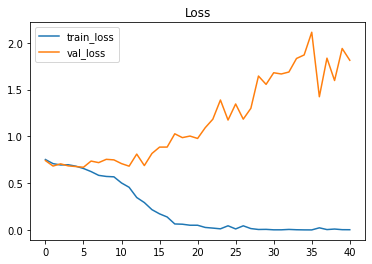

In [186]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label='train_loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.title("Loss")
plt.show()

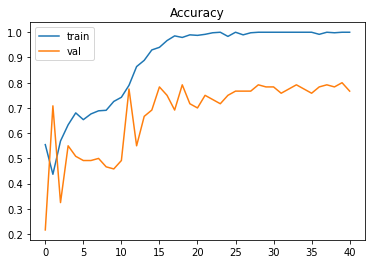

In [187]:
plt.plot(history.history["accuracy"], label='train')
plt.plot(history.history["val_accuracy"], label='val')
plt.legend()
plt.title("Accuracy")
plt.show()

### Check Feature Map

In [188]:
from tensorflow import keras

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [189]:
img_path = "./dataset_img/PD/IMG_AMJ_BW1.jpg"
img_array = get_img_array(img_path, size=(200,39))

In [190]:
img_array.shape

(1, 200, 39, 3)

In [191]:
preds = model.predict(img_array)
print("Predicted:", 'Contols' if preds == 0 else 'PD')

Predicted: PD


In [192]:
# Remove last layer's softmax
model.layers[-1].activation = None

In [193]:
layer_names = [layer.name for layer in model.layers]

In [194]:
layer_names

['conv2d_12',
 'max_pooling2d_12',
 'zero_padding2d_4',
 'conv2d_13',
 'max_pooling2d_13',
 'flatten_5',
 'dense_15',
 'dropout_10',
 'dense_16',
 'dropout_11',
 'dense_17']

In [195]:
list(filter(lambda x : x.startswith('conv2d'), layer_names))

['conv2d_12', 'conv2d_13']

In [196]:
last_conv_layer_name = list(filter(lambda x : x.startswith('conv2d'), layer_names))[-1]
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

In [197]:
np.where(heatmap == 1)

(array([24]), array([17]))

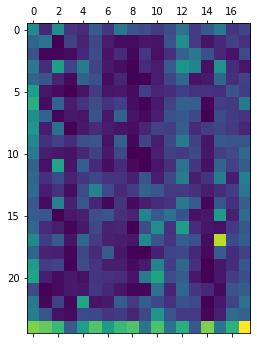

In [198]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

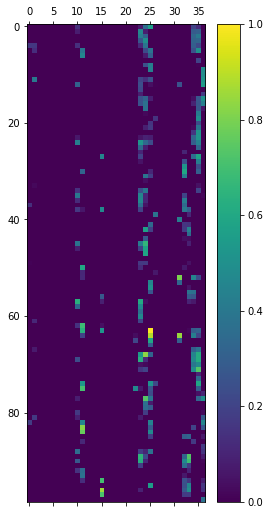

In [205]:
last_conv_layer_name = list(filter(lambda x : x.startswith('conv2d'), layer_names))[0]
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.colorbar(shrink=0.8)
plt.show()

In [209]:
heatmap.shape[1]

37

In [213]:
mean_cam_result = [np.mean(heatmap[:,idx]) for idx in range(heatmap.shape[1])]
min_cam_result = [np.min(heatmap[:,idx]) for idx in range(heatmap.shape[1])]
max_cam_result = [np.max(heatmap[:,idx]) for idx in range(heatmap.shape[1])]

In [235]:
mean_cam_result_idx = np.argsort(mean_cam_result)
mean_cam_result_idx = list(filter(lambda x : mean_cam_result[x] > 0, mean_cam_result_idx))

print(mean_cam_result_idx)
print(list(np.array(MARKERS)[np.array(mean_cam_result_idx)]))

[0, 22, 26, 1, 31, 15, 10, 33, 36, 32, 34, 11, 24, 23, 25, 35]
['LFHD', 'RFIN', 'RPSI', 'RFHD', 'LTIB', 'LFRM', 'RUPA', 'LANK', 'RTOE', 'RTIB', 'RANK', 'STRN', 'RASI', 'LASI', 'LPSI', 'LTOE']


In [236]:
max_cam_result_idx = np.argsort(max_cam_result)
max_cam_result_idx = list(filter(lambda x : max_cam_result[x] > 0, max_cam_result_idx))

print(max_cam_result_idx)
print(list(np.array(MARKERS)[np.array(max_cam_result_idx)]))

[0, 26, 1, 22, 34, 36, 32, 10, 23, 35, 33, 11, 24, 31, 15, 25]
['LFHD', 'RPSI', 'RFHD', 'RFIN', 'RANK', 'RTOE', 'RTIB', 'RUPA', 'LASI', 'LTOE', 'LANK', 'STRN', 'RASI', 'LTIB', 'LFRM', 'LPSI']


----

In [47]:
from matplotlib import cm
from PIL import Image

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


In [48]:
save_and_display_gradcam(img_path, heatmap)

TypeError: 'module' object is not callable